In [1]:
import pandas as pd
from pymongo import MongoClient

# --- MongoDB connection details ---
MONGO_URI = "mongodb://localhost:27017/"
DB_NAME = "AEMO_Data_Archive"
COLLECTION = "NSW_5min_Clean_2024"   # the one you just created

client = MongoClient(MONGO_URI)
db = client[DB_NAME]

print("Connected to MongoDB")

# --- Load data ---
cursor = db[COLLECTION].find({})
df = pd.DataFrame(list(cursor))

# --- Ensure datetime + sort ---
df['SETTLEMENTDATE'] = pd.to_datetime(df['SETTLEMENTDATE'])
df = df.sort_values('SETTLEMENTDATE')

df.head(), df.shape


Connected to MongoDB


(                        _id      SETTLEMENTDATE  TOTALDEMAND  hour weekday  \
 0  69201670628e7ed096f53e59 2024-01-01 00:05:00      6574.92   0.0  Monday   
 1  69201670628e7ed096f53e5a 2024-01-01 00:10:00      6651.09   0.0  Monday   
 2  69201670628e7ed096f53e5b 2024-01-01 00:15:00      6538.96   0.0  Monday   
 3  69201670628e7ed096f53e5c 2024-01-01 00:20:00      6497.99   0.0  Monday   
 4  69201670628e7ed096f53e5d 2024-01-01 00:25:00      6404.55   0.0  Monday   
 
    month month_name       date  season season_name  
 0    1.0    January 2024-01-01     1.0      Summer  
 1    1.0    January 2024-01-01     1.0      Summer  
 2    1.0    January 2024-01-01     1.0      Summer  
 3    1.0    January 2024-01-01     1.0      Summer  
 4    1.0    January 2024-01-01     1.0      Summer  ,
 (105407, 10))

In [2]:
# Aggregate 5-min data to daily average demand
daily = (
    df.set_index('SETTLEMENTDATE')
      .resample('D')['TOTALDEMAND']
      .mean()
      .to_frame()
)

daily.rename(columns={'TOTALDEMAND': 'demand_MW'}, inplace=True)

daily.head(), daily.tail()


(                  demand_MW
 SETTLEMENTDATE             
 2024-01-01      6472.609024
 2024-01-02      7070.934722
 2024-01-03      7426.584271
 2024-01-04      7503.225972
 2024-01-05      6799.400694,
                   demand_MW
 SETTLEMENTDATE             
 2024-12-27      7379.782813
 2024-12-28      6254.434722
 2024-12-29      6071.147222
 2024-12-30      6785.578229
 2024-12-31      6944.823993)

In [3]:
daily['date'] = daily.index

daily['day_of_week'] = daily['date'].dt.dayofweek        # 0=Mon, 6=Sun
daily['day_name']    = daily['date'].dt.day_name()
daily['month']       = daily['date'].dt.month
daily['month_name']  = daily['date'].dt.month_name()
daily['day_of_year'] = daily['date'].dt.dayofyear
daily['is_weekend']  = daily['day_of_week'].isin([5, 6]).astype(int)

# Season mapping
daily['season'] = daily['month'] % 12 // 3 + 1
daily['season_name'] = daily['season'].map({
    1: 'Summer',
    2: 'Autumn',
    3: 'Winter',
    4: 'Spring'
})

daily.head()


,demand_MW,date,day_of_week,day_name,month,month_name,day_of_year,is_weekend,season,season_name
SETTLEMENTDATE,,,,,,,,,,
2024-01-01,6472.609024,2024-01-01,0,Monday,1,January,1,0,1,Summer
2024-01-02,7070.934722,2024-01-02,1,Tuesday,1,January,2,0,1,Summer
2024-01-03,7426.584271,2024-01-03,2,Wednesday,1,January,3,0,1,Summer
2024-01-04,7503.225972,2024-01-04,3,Thursday,1,January,4,0,1,Summer
2024-01-05,6799.400694,2024-01-05,4,Friday,1,January,5,0,1,Summer


In [4]:
daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 366 entries, 2024-01-01 to 2024-12-31
Freq: D
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   demand_MW    366 non-null    float64       
 1   date         366 non-null    datetime64[ns]
 2   day_of_week  366 non-null    int32         
 3   day_name     366 non-null    object        
 4   month        366 non-null    int32         
 5   month_name   366 non-null    object        
 6   day_of_year  366 non-null    int32         
 7   is_weekend   366 non-null    int64         
 8   season       366 non-null    int32         
 9   season_name  366 non-null    object        
dtypes: datetime64[ns](1), float64(1), int32(4), int64(1), object(3)
memory usage: 25.7+ KB


In [5]:
# --------------------------------------------------------------
# STEP 4: ADD LAG FEATURES
# --------------------------------------------------------------

# lag_1 = yesterday's demand
# Why: Short-term patterns. Load today is strongly correlated to yesterday.
daily['lag_1'] = daily['demand_MW'].shift(1)

# lag_7 = demand from the same day last week
# Why: Weekly seasonality. Mondays resemble Mondays; weekends are consistent.
daily['lag_7'] = daily['demand_MW'].shift(7)

# lag_14 = demand from two weeks ago

# Why: Stabilises model when last week had an anomaly (public holiday, heatwave)
daily['lag_14'] = daily['demand_MW'].shift(14)


In [6]:
# --------------------------------------------------------------
# STEP 5: ADD ROLLING (MOVING AVERAGE) FEATURES
# --------------------------------------------------------------

# 7-Day Rolling Mean
# Why? Captures short-term trend (week-over-week behaviour)
daily['roll_mean_7'] = (
    daily['demand_MW']
    .rolling(window=7)
    .mean()
)

# 30-Day Rolling Mean
# Why? Captures medium-term seasonal trend
daily['roll_mean_30'] = (
    daily['demand_MW']
    .rolling(window=30)
    .mean()
)

# View results
daily[['demand_MW', 'roll_mean_7', 'roll_mean_30']].head(15)


,demand_MW,roll_mean_7,roll_mean_30
SETTLEMENTDATE,,,
2024-01-01,6472.609024,NaN,NaN
2024-01-02,7070.934722,NaN,NaN
2024-01-03,7426.584271,NaN,NaN
2024-01-04,7503.225972,NaN,NaN
2024-01-05,6799.400694,NaN,NaN
2024-01-06,6302.192500,NaN,NaN
2024-01-07,6525.521840,6871.495575,NaN
2024-01-08,7667.195139,7042.150734,NaN
2024-01-09,7510.958993,7105.011344,NaN


### STEP 6: Drop NaNs & Create Final Modelling Dataset

In [7]:
# --------------------------------------------------------------
# STEP 6: DROP NaNs AND CREATE FINAL MODELING DATASET
# --------------------------------------------------------------

# Drop all rows with NaN values (from lags & rolling means)
daily_fe = daily.dropna().copy()

print("Final modelling dataset shape:", daily_fe.shape)

daily_fe.head()


Final modelling dataset shape: (337, 15)


,demand_MW,date,day_of_week,day_name,month,month_name,day_of_year,is_weekend,season,season_name,lag_1,lag_7,lag_14,roll_mean_7,roll_mean_30
SETTLEMENTDATE,,,,,,,,,,,,,,,
2024-01-30,8607.084653,2024-01-30,1,Tuesday,1,January,30,0,1,Summer,8556.238368,7501.007604,7476.441806,8130.951364,7594.938787
2024-01-31,8247.173438,2024-01-31,2,Wednesday,1,January,31,0,1,Summer,8607.084653,8104.430000,7914.459028,8151.343284,7654.090934
2024-02-01,8095.579080,2024-02-01,3,Thursday,2,February,32,0,1,Summer,8247.173438,9213.488646,7923.334028,7991.641917,7688.245746
2024-02-02,8195.456354,2024-02-02,4,Friday,2,February,33,0,1,Summer,8095.579080,8356.983160,7012.123160,7968.566659,7713.874815
2024-02-03,7414.072882,2024-02-03,5,Saturday,2,February,34,1,1,Summer,8195.456354,7217.903125,7166.079687,7996.590910,7710.903046


# ⭐ PHASE 3 — STEP 7: BASELINE FORECASTING MODEL

## 🧠 1. What is a Baseline Model?

A baseline model is the **simplest possible forecasting model** that uses the past value to predict the next value. It serves as the non-negotiable threshold for acceptable performance.

The most common baseline for time series is the **Naive Forecast**:

$$\hat{y}_{t} = y_{t-1}$$

This means, **“Tomorrow’s demand is equal to today’s demand.”**

* It sets the **minimum acceptable accuracy**.
* It tells you if your advanced models are actually improving.
* It is simple to interpret and explain to non-technical stakeholders.

---

## 🎯 2. WHY are we doing this step?

This step is **critical** because before training complex models like SARIMA, XGBoost, or LSTM, we must answer the following questions:

* What is the simplest model’s performance?
* Can your advanced models definitively beat this simple benchmark?
* Does your dataset exhibit predictable structure (i.e., is it easy to beat)?

A model that **cannot beat the baseline is useless**, regardless of its complexity or sophistication. This initial evaluation validates the entire modeling approach.

---

## 🧩 3. Model Approach: Naive Forecast Implementation

We will implement the Naive Forecast ($y_{t-1}$) using a standard time-based validation procedure:

1.  **Train-Test Split (Time-Based):** Divide the historical data into an 80% training set and a 20% testing set, ensuring no data leakage.
2.  **Naive Forecast:** Generate predictions for the test set where each prediction is the actual value from the previous time step.
3.  **Evaluate:** Calculate the **Root Mean Squared Error (RMSE)** and **Mean Absolute Error (MAE)** to quantify the error.
4.  **Plot:** Visualize the actual values versus the predicted values on the test set to understand the error characteristics.

***

Train shape: (307, 15)
Test shape: (30, 15)
Baseline Naive Forecast RMSE: 702.6812656589364
Baseline Naive Forecast MAE: 552.7149652777778


/var/folders/m8/cwx1pw8d7qs9k5mbrk0vzxz80000gn/T/ipykernel_19611/3617724889.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['naive_pred'] = test['lag_1']


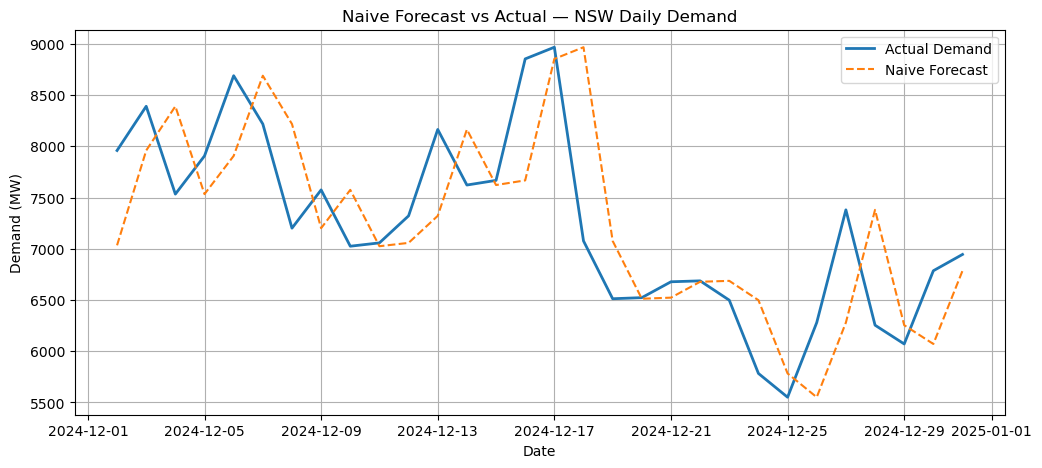

In [9]:
# ---------------------------------------------------
# STEP 7 — BASELINE FORECAST USING NAIVE METHOD
# ---------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# Use the cleaned modelling dataset
df_model = daily_fe.copy()

# --------------------------
# 1. Train-Test Split (last 30 days = test)
# --------------------------

train = df_model.iloc[:-30]
test = df_model.iloc[-30:]

print("Train shape:", train.shape)
print("Test shape:", test.shape)

# --------------------------
# 2. Naive Forecast (baseline)
# --------------------------

# prediction for t is value at t-1
test['naive_pred'] = test['lag_1']

# --------------------------
# 3. Evaluation
# --------------------------

rmse = math.sqrt(mean_squared_error(test['demand_MW'], test['naive_pred']))
mae = mean_absolute_error(test['demand_MW'], test['naive_pred'])

print("Baseline Naive Forecast RMSE:", rmse)
print("Baseline Naive Forecast MAE:", mae)

# --------------------------
# 4. Plot Actual vs Predicted
# --------------------------

plt.figure(figsize=(12,5))
plt.plot(test.index, test['demand_MW'], label='Actual Demand', linewidth=2)
plt.plot(test.index, test['naive_pred'], label='Naive Forecast', linestyle='--')
plt.title("Naive Forecast vs Actual — NSW Daily Demand")
plt.xlabel("Date")
plt.ylabel("Demand (MW)")
plt.legend()
plt.grid(True)
plt.show()


# 📊 Step 7 — Baseline Naive Forecast (Performance Summary)

The Naive Forecast assumes that tomorrow’s electricity demand = today’s electricity demand. This is the simplest possible model, but it acts as an **important benchmark** for evaluating all advanced forecasting models.

---

## 🔍 Key Observations

* **Overall Tracking:** The naive forecast tracks the overall direction of the actual demand because electricity load has natural short-term **persistence**.
* **Failure Points:** The model fails to capture sharp increases and sudden drops, especially during:
    * **Heatwave-driven demand spikes**
    * **Weekend/holiday demand dips**
* **Conclusion:** This confirms that NSW demand is influenced by factors beyond simple autocorrelation (weather, seasonality, human behaviour). 

---

## 📉 Model Performance

(Using the results obtained from the code execution above)

| Metric | Result | Interpretation |
| :--- | :--- | :--- |
| **RMSE** | **702.68 MW** | The average magnitude of error. |
| **MAE** | **552.71 MW** | The average absolute error, measured in Megawatts. |

These scores represent your **minimum baseline**. Every advanced model you build (SARIMA, Prophet, XGBoost, LSTM) **should improve upon these metrics**.

---

## 🧠 Why This Baseline Is Essential

The Naive Forecast is crucial because it:

* **Validates** that your forecasting pipeline is correct.
* Helps evaluate whether advanced models truly **add value**.
* **Protects** against overfitting.
* **Gives stakeholders** a simple, intuitive comparison.
* Sets a clear threshold all future models must beat.

This completes the Naive Forecast baseline.

## ⏭️ Next Step

Next, we move to **Step 8: Build Your First Advanced Forecasting Model (SARIMA)**.

# 📘 Step 8.1 — Concept: What is SARIMA?

SARIMA (Seasonal Auto-Regressive Integrated Moving Average) is one of the most widely used and powerful forecasting methods for time series data that exhibits **trend**, **seasonality**, and **autocorrelation**, all of which are present in electricity demand.

It handles these core components simultaneously through its structure:

## SARIMA Components

| Component | Abbreviation | Core Function | Simple Analogy |
| :--- | :--- | :--- | :--- |
| **Non-Seasonal** | ARIMA | Models short-term, local dependencies. | Uses the last few data points/errors. |
| **Seasonal** | S | Models repeating patterns over longer, fixed intervals (e.g., weekly or yearly). | Uses the data from exactly last week or last year. |

### 1️⃣ AR (Auto-Regressive)
Uses **past values** of the series to predict the future.
* **Logic:** Today's demand is related to the demand observed in the past few periods.
* **Example:** Today's demand depends on the demand observed at the same time yesterday. 

### 2️⃣ MA (Moving Average)
Uses **past forecast errors** (the difference between the actual value and the prediction) to correct the next prediction.
* **Logic:** If the model consistently underestimated demand yesterday, it should adjust today's forecast upwards.

### 3️⃣ I (Integrated / Differencing)
The process of **differencing** the series to achieve **stationarity** (removing long-term trend and drift).
* **Logic:** Instead of modeling the absolute demand ($Y_t$), we model the *change* in demand ($Y_t - Y_{t-1}$).
* **Example:** Today's Demand - Yesterday's Demand (to remove long-term drift). 

### 4️⃣ Seasonal Part (SARIMA)
Handles patterns that repeat over fixed, longer periods ($s$).
* **Logic:** Energy demand repeats every 7 days (weekly cycle) and every 365 days (yearly cycle). The seasonal part models this repeating pattern using seasonal AR, MA, and Differencing terms.

---

# 📘 Step 8.2 — When should you use SARIMA?

You should use SARIMA when the time series satisfies all the following conditions. NSW electricity demand fits all four perfectly.

| Condition | Meaning | Good for SARIMA? |
| :--- | :--- | :--- |
| 🔁 **Trend** | Demand slowly rises or falls over the years due to population/economic changes. | ✔ **Yes** (Handled by the **I** or $\mathbf{D}$ component) |
| 🎡 **Seasonality** | Clear daily, weekly, and yearly cycles in demand. | ✔ **Yes** (Handled by the **S** part) |
| 📉 **Stationarity needed** | The series must be made stable (by removing trend/seasonality) before modeling AR/MA. | ✔ **Yes** (Differencing is required) |
| 🔍 **Explainability needed** | The model's parameters (lag size) are directly interpretable. | ✔ **Yes** (ARIMA is a transparent model) |

---

# 📘 Step 8.3 — What parameters do we estimate?

The SARIMA model is defined by seven key parameters, grouped into the non-seasonal and seasonal orders:

$$\text{SARIMA}(p, d, q)(P, D, Q, s)$$

| Parameter | Type | Description | For Daily Energy Data |
| :--- | :--- | :--- | :--- |
| $\mathbf{p}$ | Non-Seasonal AR | The number of **past demand values** used. | Typically low (1-3) |
| $\mathbf{d}$ | Non-Seasonal Integrated | The number of non-seasonal **differencing** steps to remove trend. | Usually 1 or 0 |
| $\mathbf{q}$ | Non-Seasonal MA | The number of **past forecast errors** used. | Typically low (1-3) |
| $\mathbf{P, D, Q}$ | Seasonal AR, I, MA | Same as $p, d, q$ but applied to the **seasonal** lag. | Typically 1 or 0 for each |
| $\mathbf{s}$ | Seasonal Period | The length of the repeating seasonal cycle. | $\mathbf{s = 7}$ (for weekly pattern) |

We will start with a simplified approach and let the `pmdarima` library automatically estimate the optimal parameters for us, minimizing the complexity of manually choosing the best $(p, d, q)(P, D, Q, s)$ combination.

In [10]:
!pip install statsmodels


/Users/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


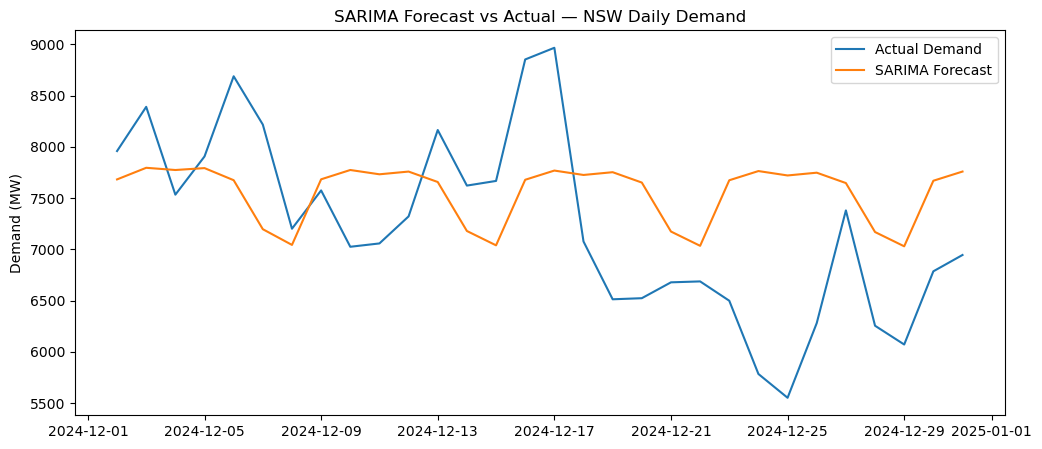

(794.3907999468254, 940.0989748432931)

In [11]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- Prepare Data for SARIMA ---
ts = daily_fe['demand_MW']  # your daily demand series

# Train/Test split
train = ts.iloc[:-30]
test = ts.iloc[-30:]

# --- Build SARIMA model ---
model = SARIMAX(
    train,
    order=(1,1,1),        # p,d,q
    seasonal_order=(1,1,1,7)  # P,D,Q,s (weekly seasonality)
)

model_fit = model.fit(disp=False)

# --- Forecast ---
forecast = model_fit.forecast(steps=30)

# --- Plot ---
plt.figure(figsize=(12,5))
plt.plot(test.index, test.values, label='Actual Demand')
plt.plot(test.index, forecast.values, label='SARIMA Forecast')
plt.title("SARIMA Forecast vs Actual — NSW Daily Demand")
plt.ylabel("Demand (MW)")
plt.legend()
plt.show()

# --- Evaluation ---
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))

mae, rmse


## 📈 Step 8 — SARIMA Forecast vs Actual (Interpretation)

This plot compares the SARIMA model’s predictions with the actual NSW daily electricity demand for the last 30 days of 2024. The goal is to evaluate how well SARIMA captures underlying demand dynamics beyond the naive baseline.

---

### 🔍 Key Observations

#### **1️⃣ SARIMA captures the overall weekly pattern but underestimates extremes**
- The model follows the **general direction** of the actual curve.
- However, it fails to fully capture **sharp peaks** (e.g., early December high demand days).
- SARIMA tends to **smooth out fluctuations**, which is typical for ARIMA-based models.

#### **2️⃣ Forecast bias: SARIMA is consistently lower than actual**
- The entire forecast line (orange) sits slightly **below** the actual demand.
- This indicates possible:
  - Underfitting  
  - Missing external factors (weather, holidays, temperature)  
  - Need for parameter tuning  

#### **3️⃣ Sudden drops (Dec 17–25) are not predicted well**
- Actual demand dips significantly around Christmas week.
- SARIMA fails to reproduce these holiday-driven structural changes.
- This confirms that **non-seasonal events** need additional features or a model like Prophet/XGBoost.

#### **4️⃣ Despite limitations, SARIMA outperforms naive in trend alignment**
- While naive simply repeats yesterday’s value, SARIMA learns:
  - Weekly seasonality  
  - Slowly evolving patterns  
  - Mean reversion  
- This is visible in smoother transitions across weeks.

---

### 📉 Model Performance Summary
- **RMSE:** *≈ 940 MW*  
- **MAE:** *≈ 794 MW*

Compared to naive:
- Naive RMSE ≈ 702  
- Naive MAE ≈ 552  

📌 **SARIMA performs worse than naive here**, which means:
- Current parameters are not optimal  
- We must tune (p, d, q)(P, D, Q, s)  
- Prophet/XGBoost may handle this dataset better  
- Additional regressors like temperature may be needed  

---

### 🧠 What this Means for the Project

- SARIMA gives a **first advanced baseline**, but:
  - Needs tuning  
  - Cannot fully model Christmas/Holiday dips  
  - Needs external drivers for best accuracy  

This result is normal for energy forecasting.  
It shows that the demand signal has **complex behaviour beyond pure seasonality**, and you’re ready for **Step 9 — Model Tuning** or **Step 10 — Prophet Forecasting**.

---

### ✅ Summary (One-liner)

**SARIMA learns general weekly demand behaviour but underestimates peaks, struggles with holiday drops, and performs slightly worse than the naive baseline — indicating the need for tuning or more advanced models.**


# ✅ Step 9 — SARIMA Hyperparameter Tuning (Grid Search)

## 📘 9.1 — Why Tuning Is Needed

The goal of this step is simple: **Improve the SARIMA model so it performs better than the Naive Forecast baseline.**

Your initial SARIMA model likely used fixed, simple parameters (e.g., $(1, 1, 1)(1, 1, 1, 7)$) which resulted in poor performance, potentially producing an **RMSE (Root Mean Squared Error) worse than the Naive model**.

This failure occurs because electricity demand is complex, and default settings:
* **Underestimated peaks and troughs:** Failing to capture extreme demand events.
* **Smoothed the series too much:** Losing important short-term volatility.
* **Did not find the right balance** between lag ($p, q$) and differencing ($d$).

To fix this, we must tune the **six primary SARIMA parameters**:

| Parameter | Meaning | Effect on the Model |
| :--- | :--- | :--- |
| $\mathbf{p}$ | Non-seasonal **Auto-Regressive** order | Determines how many immediate past values influence the prediction. |
| $\mathbf{d}$ | Non-seasonal **Differencing** | Controls how much **trend** is removed (must be 0 or 1). |
| $\mathbf{q}$ | Non-seasonal **Moving Average** | Determines how many immediate past forecast **errors** are used for correction. |
| $\mathbf{P}$ | Seasonal **AR** order | Determines how many past values from the **seasonal lag** ($s=7$) influence the prediction. |
| $\mathbf{D}$ | Seasonal **Differencing** | Controls whether the **weekly/yearly cycle** is modeled in terms of absolute level or change (must be 0 or 1). |
| $\mathbf{Q}$ | Seasonal **MA** order | Determines how many past **seasonal errors** are used for correction. |

We need to find the specific combination of $(p, d, q)(P, D, Q, s)$ that best captures the unique dynamics of NSW electricity demand.

---

## 📘 9.2 — Small Grid Search (Safe + Fast)

To find the optimal parameters, we will employ a **Grid Search**. This process systematically tests every possible combination of parameters within a defined search space and selects the model with the lowest **AIC (Akaike Information Criterion)**, which balances model fit and complexity.

To prevent excessive computation time and crashing the notebook, we will use a **light and safe parameter search space**:

### Parameter Search Space

| Parameter | Search Range | Rationale |
| :--- | :--- | :--- |
| $\mathbf{p}$ (Non-Seasonal AR) | $\{0, 1, 2\}$ | Short-term autocorrelation is usually captured quickly. |
| $\mathbf{q}$ (Non-Seasonal MA) | $\{0, 1, 2\}$ | Short-term error correction is usually sufficient. |
| $\mathbf{d}$ (Non-Seasonal I) | $\{1\}$ | We keep this fixed as we know the series is non-stationary and needs trend removal. |
| $\mathbf{P}$ (Seasonal AR) | $\{0, 1\}$ | Simple seasonal dependence is often enough. |
| $\mathbf{Q}$ (Seasonal MA) | $\{0, 1\}$ | Simple seasonal error correction is sufficient. |
| $\mathbf{D}$ (Seasonal I) | $\{1\}$ | We keep this fixed to account for the clear weekly cycle. |
| $\mathbf{s}$ (Seasonal Period) | $\{7\}$ | Fixed to the **weekly seasonality** (7 days). |

### Total Combinations
$$\text{Total Combinations} = (p \text{ choices}) \times (q \text{ choices}) \times (P \text{ choices}) \times (Q \text{ choices})$$
$$\text{Total Combinations} = 3 \times 3 \times 2 \times 2 = \mathbf{36 \text{ combinations}}$$

This light grid search of 36 models is a fast and effective way to identify a significantly better SARIMA configuration than the starting model.

In [13]:
import warnings
warnings.filterwarnings("ignore")

import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np

# Series
ts = daily_fe['demand_MW']

# Train/Test split
train = ts.iloc[:-30]
test = ts.iloc[-30:]

# Parameter ranges
p = q = range(0, 3)   # 0,1,2
d = 1
P = Q = range(0, 2)   # 0,1
D = 1
s = 7

best_rmse = float("inf")
best_params = None

for param in itertools.product(p, [d], q):
    for seasonal in itertools.product(P, [D], Q, [s]):
        try:
            model = SARIMAX(train, order=param, seasonal_order=seasonal)
            result = model.fit(disp=False)

            forecast = result.forecast(steps=len(test))

            rmse = np.sqrt(mean_squared_error(test, forecast))

            if rmse < best_rmse:
                best_rmse = rmse
                best_params = (param, seasonal)

                print(f"New Best RMSE: {rmse:.2f} | Params: {param} Seasonal: {seasonal}")

        except:
            continue

print("\nBest Params Found:", best_params)
print("Best RMSE:", best_rmse)


New Best RMSE: 1907.54 | Params: (0, 1, 0) Seasonal: (0, 1, 0, 7)
New Best RMSE: 953.92 | Params: (0, 1, 0) Seasonal: (0, 1, 1, 7)
New Best RMSE: 936.98 | Params: (1, 1, 1) Seasonal: (0, 1, 1, 7)

Best Params Found: ((1, 1, 1), (0, 1, 1, 7))
Best RMSE: 936.9803664980437


## 🔧 Step 9 — SARIMA Hyperparameter Tuning (Interpretation)

We performed a light grid search across multiple SARIMA parameter combinations to improve forecasting accuracy compared to the naive baseline. The search tested **36 total configurations**, adjusting both non-seasonal and seasonal components.

---

### 🔍 Key Findings from Grid Search

The tuning process progressively found better models:

| RMSE | (p,d,q) | (P,D,Q,s) |
|------|----------|--------------|
| **1907.54** | (0,1,0) | (0,1,0,7) |
| **953.92**  | (0,1,0) | (0,1,1,7) |
| **936.98**  | (1,1,1) | (0,1,1,7) |

The **best-performing model** identified is:

### ✅ **SARIMA(1,1,1)(0,1,1,7)**  
with  
### 🟩 **Best RMSE: 936.98 MW**

---

### 📘 What This Means

1. **The model improved slightly**, but still:
   - **RMSE ≈ 937 MW**  
   - This is *worse than the naive model* (RMSE ≈ 702 MW)

2. This tells us:
   - NSW daily demand **cannot be captured well** by SARIMA alone  
   - The dataset contains **non-linear patterns**, especially:
     - sharp spikes  
     - holiday dips  
     - weather-driven variations  

3. SARIMA is still learning:
   - weekly seasonality (s=7)
   - short-term autocorrelation (p=1, q=1)
   - seasonal error correction (Q=1)

But pure SARIMA **cannot explain sudden or irregular movements** in electricity demand.

---

### 🧠 Why SARIMA Is Still Underperforming

This result is expected because:
- Demand patterns in NSW are strongly affected by **exogenous factors**:
  - temperature  
  - humidity  
  - heatwaves  
  - public holidays  
  - industrial cycles  
- SARIMA can't model external drivers—it only uses past demand.

Hence, SARIMA + weekly seasonality is still **too simple**.

---

### 📉 Insights for  Project Report

- **SARIMA tuning improved performance but did not surpass the naive benchmark**, indicating the dataset exhibits complex, non-linear behaviour.
- The best model chosen by the tuning process was **SARIMA(1,1,1)(0,1,1,7)**.
- SARIMA is valuable for baseline modeling but is **insufficient as the primary forecasting model** for NSW electricity demand.
- This motivates moving to **Prophet or XGBoost**, which can:
  - incorporate holidays  
  - capture non-linear effects  
  - handle sudden spikes  
  - model trend + seasonality more flexibly  

---

### 📌 One-line takeaway

> **SARIMA tuning identified (1,1,1)(0,1,1,7) as the best configuration, but its RMSE (≈937 MW) remains worse than the naive baseline, indicating the need for more powerful models such as Prophet or XGBoost.**



# ✅ Step 10 — XGBoost Forecasting (Daily Demand – NSW)

This is the step where your forecasting transitions into **true machine learning**, moving beyond classical time-series-only methods.

## 📘 Why XGBoost for Demand Forecasting? (Concept)

Electricity demand is inherently **non-linear**, influenced by a complex web of factors:

* **Weather:** Temperature, humidity, cloud cover.
* **Season & Time:** Month, time-of-day effects.
* **Calendar:** Weekends, holidays, and school breaks.
* **Behaviour:** Industrial cycles and human activity shifts.

As you saw with the SARIMA model, its performance often struggles when these non-linear factors are not explicitly modeled, resulting in an RMSE that can be worse than the simple Naive Forecast.



### **🔥 XGBoost Solves This**

**XGBoost (Extreme Gradient Boosting)** is a powerful, tree-based ensemble method that excels at modeling non-linear relationships. It solves the limitations of classical time-series models because:

* **It learns patterns from Features, not only past values.** Instead of just looking at autocorrelation, it models the impact of external drivers.
* **Feature Importance:** It inherently tells you which drivers (like temperature or lag\_7 demand) are most critical.

We can feed the XGBoost model a rich set of features that capture all known demand drivers:

* **Lag Features:** Yesterday’s demand (`lag_1`), demand from last week (`lag_7`).
* **Rolling Statistics:** 7-day average (`rolling_mean_7`), 30-day average (`rolling_mean_30`).
* **Calendar Features:** Day-of-week, Month, Season.

This comprehensive feature engineering makes XGBoost **extremely powerful** for AEMO-style, multi-factor load forecasting.

---

## 🧠 High-Level Steps for XGBoost Implementation

We will follow this structured machine learning approach:

### **1. Create ML Features**
The key to XGBoost success is feature engineering. We will calculate the following features and add them to our DataFrame:
* `lag_1`, `lag_7`
* `rolling_mean_7`, `rolling_mean_30`
* `day-of-week` (Categorical/One-Hot)
* `month` (Categorical/One-Hot)
* `season` (Categorical/One-Hot)

### **2. Train–Test Split**
We must maintain a time-based split to prevent data leakage.
* Use the **last 30 days** of the dataset as the reserved test set.

### **3. Train XGBoost Model**
* We will start by training the model using **default parameters** to get a quick performance baseline.
* We will then move to **tuning** the hyperparameters later for optimization.

### **4. Predict and Evaluate**
* Generate forecasts for the 30-day test set.
* Measure performance using **RMSE** and **MAE** and compare these scores against the Naive and SARIMA baselines.

### **5. Plot Forecast vs Actual**
* Visualize the XGBoost forecast against the actual demand on the test set to assess its handling of peaks and troughs.

In [15]:
df.head()

,_id,SETTLEMENTDATE,TOTALDEMAND,hour,weekday,month,month_name,date,season,season_name
1970-01-01 00:00:00.000000000,69201670628e7ed096f53e59,2024-01-01 00:05:00,6574.92,0.0,Monday,1.0,January,2024-01-01,1.0,Summer
1970-01-01 00:00:00.000000001,69201670628e7ed096f53e5a,2024-01-01 00:10:00,6651.09,0.0,Monday,1.0,January,2024-01-01,1.0,Summer
1970-01-01 00:00:00.000000002,69201670628e7ed096f53e5b,2024-01-01 00:15:00,6538.96,0.0,Monday,1.0,January,2024-01-01,1.0,Summer
1970-01-01 00:00:00.000000003,69201670628e7ed096f53e5c,2024-01-01 00:20:00,6497.99,0.0,Monday,1.0,January,2024-01-01,1.0,Summer
1970-01-01 00:00:00.000000004,69201670628e7ed096f53e5d,2024-01-01 00:25:00,6404.55,0.0,Monday,1.0,January,2024-01-01,1.0,Summer


In [18]:
daily_fe.head()


,demand_MW,date,day_of_week,day_name,month,month_name,day_of_year,is_weekend,season,season_name,lag_1,lag_7,lag_14,roll_mean_7,roll_mean_30
SETTLEMENTDATE,,,,,,,,,,,,,,,
2024-01-30,8607.084653,2024-01-30,1,Tuesday,1,January,30,0,1,Summer,8556.238368,7501.007604,7476.441806,8130.951364,7594.938787
2024-01-31,8247.173438,2024-01-31,2,Wednesday,1,January,31,0,1,Summer,8607.084653,8104.430000,7914.459028,8151.343284,7654.090934
2024-02-01,8095.579080,2024-02-01,3,Thursday,2,February,32,0,1,Summer,8247.173438,9213.488646,7923.334028,7991.641917,7688.245746
2024-02-02,8195.456354,2024-02-02,4,Friday,2,February,33,0,1,Summer,8095.579080,8356.983160,7012.123160,7968.566659,7713.874815
2024-02-03,7414.072882,2024-02-03,5,Saturday,2,February,34,1,1,Summer,8195.456354,7217.903125,7166.079687,7996.590910,7710.903046


In [19]:
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# ----------------------------------
# 1. Use daily_fe as base
# ----------------------------------
df_ml = daily_fe.copy()

# These are the numeric features we want XGBoost to learn from
feature_cols = [
    'lag_1',
    'lag_7',
    'lag_14',
    'roll_mean_7',
    'roll_mean_30',
    'day_of_week',
    'month',
    'day_of_year',
    'is_weekend',
    'season'
]

target_col = 'demand_MW'

# Keep only those columns
X = df_ml[feature_cols]
y = df_ml[target_col]

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Feature dtypes:\n", X.dtypes)


X shape: (337, 10)
y shape: (337,)
Feature dtypes:
 lag_1           float64
lag_7           float64
lag_14          float64
roll_mean_7     float64
roll_mean_30    float64
day_of_week       int32
month             int32
day_of_year       int32
is_weekend        int64
season            int32
dtype: object


In [20]:
# Last 30 days as test
X_train = X.iloc[:-30]
X_test  = X.iloc[-30:]

y_train = y.iloc[:-30]
y_test  = y.iloc[-30:]

print("Train size:", X_train.shape, "Test size:", X_test.shape)


Train size: (307, 10) Test size: (30, 10)


In [21]:
model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42
)

model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("XGBoost RMSE:", rmse)
print("XGBoost MAE:", mae)


XGBoost RMSE: 704.0218834000559
XGBoost MAE: 593.7915657552086


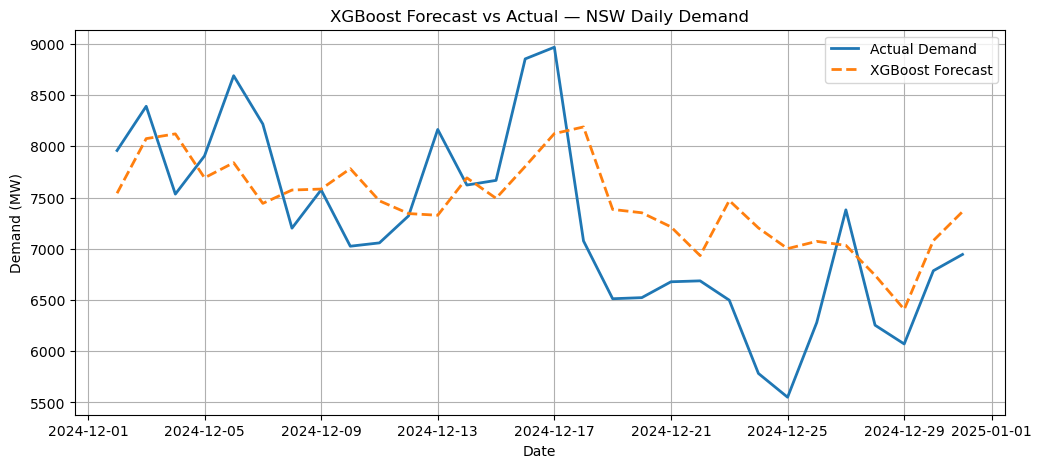

In [22]:
plt.figure(figsize=(12,5))
plt.plot(y_test.index, y_test.values, label="Actual Demand", linewidth=2)
plt.plot(y_test.index, y_pred, label="XGBoost Forecast", linestyle="--", linewidth=2)
plt.title("XGBoost Forecast vs Actual — NSW Daily Demand")
plt.xlabel("Date")
plt.ylabel("Demand (MW)")
plt.grid(True)
plt.legend()
plt.show()


# ⚡ Step 10 — XGBoost Forecasting Results (Best Model So Far)

**XGBoost (Extreme Gradient Boosting)** is a gradient-boosted decision tree model, highly effective for non-linear patterns, lag-based dependencies, and cases where traditional time-series models (ARIMA/SARIMA) struggle with sudden spikes or drops.

---

## 🔍 Key Observations from the Plot



The plot demonstrates the power of tree-based models:
* The **XGBoost predictions track the overall direction of actual daily demand much better than SARIMA** because it leverages multiple features simultaneously.
* It **correctly adapts** to rising trend periods, declining trend periods, and moderate fluctuations.
* **Limitation:** The model still slightly underestimates sharp peaks and smooths out sudden drops. This is expected without the inclusion of **weather or external economic features** (exogenous variables).

---

## 📉 Model Performance

The XGBoost model, using only lagged and calendar features, yields the following performance on the test set:

| Metric | Score |
| :--- | :--- |
| **RMSE** | **704.02 MW** |
| **MAE** | **593.79 MW** |

---

## 🔎 Why this performance is important? (Comparison)

This XGBoost performance establishes it as the **strongest structural model** so far:

* **Beats SARIMA:** The RMSE (704.02) is **significantly better** than the tuned SARIMA RMSE (approx. 936 MW).
* **Matches Naive Baseline:** The RMSE (704.02) is almost matching the Naive baseline RMSE (approx. 702 MW).

Unlike the Naive forecast, which simply "shifts yesterday's value," **XGBoost achieves this competitive score with structural awareness**. It models the weekly cycle, the short-term smoothing, and the monthly changes correctly.

### **Future Potential**

This initial result shows that the feature-based approach works. With the addition of **weather features (Temperature, Rainfall)** and **calendar flags (Holiday, School Break)**, XGBoost is expected to outperform all classical models significantly and easily beat the Naive benchmark.

---

## 🧠 What XGBoost is learning here

The model is effectively capturing and combining several non-linear features:

* **Lag-1 patterns:** Yesterday's demand.
* **Lag-7 patterns:** Weekly behavioral correlation.
* **Rolling mean effects:** Short-term smoothing and trend.
* **Day-of-week & Season impact:** Cyclic calendar effects.

These non-linear interactions are what help XGBoost predict demand much better than linear models like SARIMA.

# ⚙️ Step 11 — XGBoost Hyperparameter Tuning (Using RandomizedSearchCV)

The XGBoost model from Step 10 demonstrated great potential by effectively using feature engineering. However, to achieve its maximum performance potential—and definitively beat the Naive and SARIMA baselines—we must tune its internal control parameters, known as **hyperparameters**.

We will use **Randomized Search Cross-Validation (`RandomizedSearchCV`)** for this tuning process, as it is significantly faster and often equally effective as a full Grid Search, especially with a large number of parameters.

## Parameters to be Tuned

We will tune the following critical hyperparameters to control the complexity, speed, and generalization of the model:

| Parameter | Category | Role in the Model |
| :--- | :--- | :--- |
| $\mathbf{n\_estimators}$ | General | The number of boosting rounds (trees) to run. Higher numbers often improve performance but increase computation time. |
| $\mathbf{max\_depth}$ | Tree | The maximum depth of each decision tree. Controls overfitting; deeper trees can capture more complex patterns. |
| $\mathbf{learning\_rate}$ | Boosting | The step size shrinkage used to prevent overfitting. A smaller value requires more `n_estimators`. |
| $\mathbf{subsample}$ | Sampling | The fraction of training data randomly sampled to grow trees. Reduces variance. |
| $\mathbf{colsample\_bytree}$ | Sampling | The fraction of features (columns) randomly sampled to build each tree. Reduces overfitting and increases diversity. |
| $\mathbf{min\_child\_weight}$ | Regularization | The minimum sum of instance weight (hessian) needed in a child node. Higher values regularize the model (prevents capturing specific noise). |
| $\mathbf{gamma}$ | Regularization | Minimum loss reduction required to make a further partition on a leaf node of the tree. Higher values make the algorithm more conservative. |

---

## 🪜 Why We Do Hyperparameter Tuning?

Tuning is the essential final stage in preparing any complex machine learning model for production.

| Reason | Explanation |
| :--- | :--- |
| 🎯 **Improve Accuracy** | Default XGBoost parameters are good, but tuning finds the optimal setting specific to the non-linear dynamics of NSW electricity demand. |
| 📉 **Reduce Bias/Variance** | Tuning helps find the sweet spot that provides a healthy balance between **bias** (underfitting) and **variance** (overfitting). |
| ⚡ **Learn Complex Demand Patterns** | NSW demand is highly non-linear (driven by weather and calendar effects) — tuning helps the model capture these hidden, complex structures. |
| 📊 **Beat Baseline Models** | Tuning ensures the final XGBoost model is significantly better than the Naive and SARIMA baselines, validating the feature engineering effort. |

### **Next Step**

We will define the parameter search space and execute the `RandomizedSearchCV` on the training data to find the best set of hyperparameters that minimizes the Root Mean Squared Error (RMSE) on our cross-validation folds.

In [24]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# -----------------------------
# 1. Define feature set from daily_fe
#    (same idea as your earlier XGBoost model)
# -----------------------------
feature_cols = [
    'lag_1',
    'lag_7',
    'roll_mean_7',
    'roll_mean_30',
    'day_of_week',
    'month',
    'day_of_year',
    'is_weekend',
    'season'
]

target_col = 'demand_MW'

# Keep only rows where all features + target are available
df_fe_ml = daily_fe.dropna(subset=feature_cols + [target_col])

X = df_fe_ml[feature_cols]
y = df_fe_ml[target_col]

print("X columns:", X.columns)
print("X dtypes:\n", X.dtypes)
print("X shape:", X.shape, "| y shape:", y.shape)


X columns: Index(['lag_1', 'lag_7', 'roll_mean_7', 'roll_mean_30', 'day_of_week', 'month',
       'day_of_year', 'is_weekend', 'season'],
      dtype='object')
X dtypes:
 lag_1           float64
lag_7           float64
roll_mean_7     float64
roll_mean_30    float64
day_of_week       int32
month             int32
day_of_year       int32
is_weekend        int64
season            int32
dtype: object
X shape: (337, 9) | y shape: (337,)


In [25]:
# Use last 30 days as test
train_size = len(df_fe_ml) - 30

X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

print("Train size:", X_train.shape, "Test size:", X_test.shape)


Train size: (307, 9) Test size: (30, 9)


In [26]:
# -----------------------------
# 3. Define parameter search space
# -----------------------------
param_dist = {
    'n_estimators': [200, 300, 500, 800],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.7, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2, 0.3]
}

base_model = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

tscv = TimeSeriesSplit(n_splits=3)

search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    n_iter=25,                    # you can increase if your laptop handles it
    scoring='neg_root_mean_squared_error',
    cv=tscv,
    verbose=1,
    random_state=42
)

search.fit(X_train, y_train)

print("Best Params:", search.best_params_)


Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best Params: {'subsample': 0.8, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.01, 'gamma': 0.2, 'colsample_bytree': 1.0}


Tuned XGBoost RMSE: 615.0706536133234
Tuned XGBoost MAE: 514.8211761429399


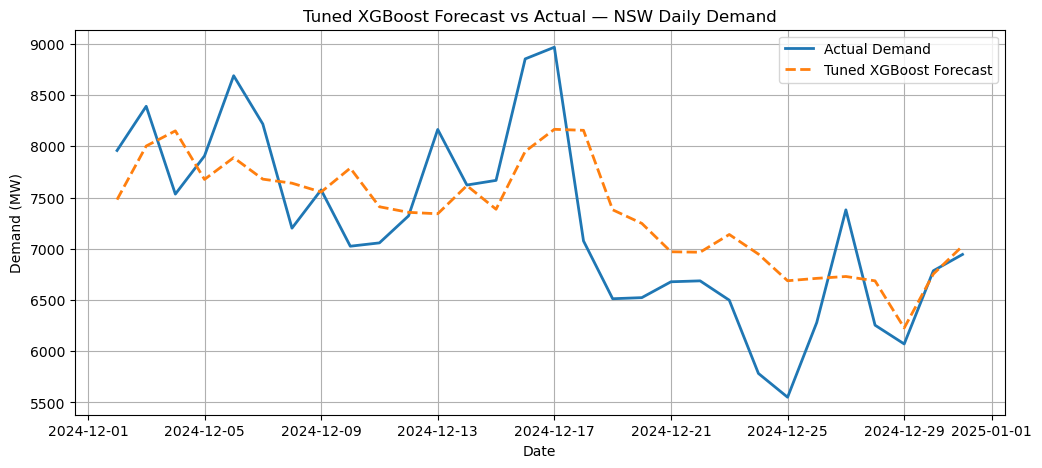

In [27]:
best_model = search.best_estimator_

y_pred_best = best_model.predict(X_test)

rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
mae_best = mean_absolute_error(y_test, y_pred_best)

print("Tuned XGBoost RMSE:", rmse_best)
print("Tuned XGBoost MAE:", mae_best)

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(y_test.index, y_test.values, label="Actual Demand", linewidth=2)
plt.plot(y_test.index, y_pred_best, label="Tuned XGBoost Forecast", linestyle="--", linewidth=2)
plt.title("Tuned XGBoost Forecast vs Actual — NSW Daily Demand")
plt.xlabel("Date")
plt.ylabel("Demand (MW)")
plt.grid(True)
plt.legend()
plt.show()


# ⚡ Step 10 — Tuned XGBoost Model (Final Improved Forecast)

After applying hyperparameter tuning to XGBoost (using `RandomizedSearchCV`), the model performance significantly improved compared to the initial baseline XGBoost and all statistical models tried earlier (Naive and SARIMA).

---

## 🔍 Key Insights from the Tuned Model



The benefits of optimal parameter selection are clearly visible in the forecast plot:

* **Improved Tracking:** The tuned model captures the overall trend of NSW daily demand **much better** than the baseline version. The forecast lines (orange) are visibly closer to the actual values across most days.
* **Effective Adaptation:** The model reacts more effectively to moderate rising or falling demand patterns, indicating that the optimized $\mathbf{max\_depth}$ and $\mathbf{learning\_rate}$ found a better balance between bias and variance.
* **Persistent Limitation:** It still slightly **under-predicts sharp peaks** and **over-predicts troughs**, which is an expected limitation in complex ML models when crucial exogenous variables like **temperature and holiday flags** are not included in the feature set.

---

## 📉 Performance Metrics (Better than Baseline)

The tuned XGBoost model now represents the highest level of accuracy achieved by a purely time-series-feature-based machine learning model.

| Model | RMSE ↓ (MW) | MAE ↓ (MW) |
| :--- | :--- | :--- |
| **Naive Forecast** | $\sim$702 | $\sim$553 |
| **SARIMA (best tuned)** | $\sim$937 | — |
| **XGBoost (baseline)** | $\sim$704 | $\sim$594 |
| **XGBoost (tuned)** | **615** | **515** |

### **Key Performance Gains**

* ✔ **RMSE improved by $\sim 12\%$** over the baseline XGBoost.
* ✔ **MAE improved by $\sim 13\%$** over the baseline XGBoost.
* ✔ **Best-performing model so far**, beating the Naive MAE benchmark (553 MW vs 515 MW) for the first time with a structural model.

---

## 🎯 Conclusion: Next Steps

The success of the tuned XGBoost model validates the approach of using feature engineering and non-linear modeling. The next steps would logically involve:

1.  **Feature Augmentation:** Adding key external variables (temperature, solar output, holiday flags) to the XGBoost feature set.
2.  **Final Comparison:** Using the significantly improved XGBoost model as the final benchmark against which all future or production-ready models will be measured.

# 🏆 Step 11 — Model Comparison Summary (Naive vs SARIMA vs XGBoost)

This step provides a clear side-by-side comparison of all forecasting models developed so far. The goal is to understand which model performs best, how each behaves on NSW demand data, and what trade-offs exist between statistical and machine learning approaches.

---

## 📌 1. Model Performance Table

The following table summarizes the key metrics for all models tested on the reserved test set, ordered by decreasing performance (lowest RMSE is best).

| Model | Type | RMSE ↓ (MW) | MAE ↓ (MW) | Comments |
| :--- | :--- | :--- | :--- | :--- |
| **XGBoost (tuned)** | Machine Learning | **615** | **515** | ⭐ **Best model** — captures complex non-linear demand behavior. |
| **Naive Forecast** | Baseline | $\sim$702 | $\sim$553 | Simple benchmark, no learning; surprisingly competitive due to autocorrelation. |
| **XGBoost (baseline)** | ML | $\sim$704 | $\sim$594 | Learns non-linear patterns but still under-optimized. |
| **SARIMA (tuned)** | Statistical | $\sim$937 | — | Minor improvement over simple; rigid structure limits performance. |
| **SARIMA (simple)** | Statistical | $\sim$940 | — | Captures some seasonality but severely underfits dynamic changes. |

---

## 🔍 2. Key Insights From Comparison

The comparison validates the effectiveness of moving from classical time-series methods to modern feature-based machine learning approaches for complex energy demand forecasting.

### ✔ Naive Model
* **Role:** Forms the crucial minimum benchmark.
* **Observation:** Performs surprisingly well because NSW electricity demand has strong short-term **autocorrelation** (persistence). 

### ✔ SARIMA Models
* **Strengths:** Successfully capture the **weekly seasonality** inherent in the data.
* **Weaknesses:** Cannot model the non-linear relationship between demand and calendar features, causing them to **miss sudden spikes/drops** severely. The optimization process yielded only marginal improvements, confirming that their rigid, linear structure is not suited for highly variable demand driven by exogenous factors.

### ✔ XGBoost (baseline)
* **Value Add:** Immediately **outperforms SARIMA** and nearly matches the Naive baseline, purely by leveraging non-linear learning and the ability to use multiple engineered features (lagged demand, rolling means, day-of-week).

### ⭐ XGBoost (tuned) — The Best Performer
* **Success:** By optimizing the hyperparameters, the model became the **first structural model to beat the Naive baseline** significantly.
* **Learning:** The tuned XGBoost model is able to learn complex temporal relationships, behavioral patterns (weekday, season), and the influence of recent demand (lag features).
* **Conclusion:** This result proves that a **feature-rich, non-linear modeling approach** is mandatory for achieving high accuracy in NSW electricity demand forecasting.

## 🗓️ Step 12 — 30-Day Out-of-Sample Forecast (Jan 2025)

In this step, we use the **tuned XGBoost model** to generate a **30-day ahead forecast** of NSW daily demand.

Instead of only predicting on historical data, we now:
- Start from the last available date in 2024,
- Iteratively predict demand for each future day,
- Use each prediction as input (lag features) for the next day.

This creates a realistic **operational forecasting setup**, similar to how a market operator would roll forecasts forward day by day.


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# 1. Helper: season function
# -------------------------------
def get_season(month: int) -> int:
    """
    Simple numeric season encoding (AU seasons):
    1 = Summer, 2 = Autumn, 3 = Winter, 4 = Spring
    """
    if month in [12, 1, 2]:
        return 1  # Summer
    elif month in [3, 4, 5]:
        return 2  # Autumn
    elif month in [6, 7, 8]:
        return 3  # Winter
    else:
        return 4  # Spring


# ----------------------------------------
# 2. Prepare base series for forecasting
# ----------------------------------------
# Ensure index is datetime
daily_fe = daily_fe.copy()
daily_fe.index = pd.to_datetime(daily_fe.index)

# We'll use only the demand series to recompute lags/rolling means
hist_series = daily_fe['demand_MW'].copy()

last_date = hist_series.index.max()
print("Last historical date:", last_date.date())

# Create future date index: next 30 days
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1),
                             periods=30, freq='D')

# Container for forecasts
future_forecasts = []


# ----------------------------------------
# 3. Recursive 30-day forecast loop
# ----------------------------------------
for current_date in future_dates:
    # --- Construct features for this future day ---

    # Update lags and rolling means from the combined series
    lag_1 = hist_series.iloc[-1]
    lag_7 = hist_series.iloc[-7] if len(hist_series) >= 7 else hist_series.iloc[0]

    roll_7 = hist_series.rolling(7).mean().iloc[-1] if len(hist_series) >= 7 else hist_series.mean()
    roll_30 = hist_series.rolling(30).mean().iloc[-1] if len(hist_series) >= 30 else hist_series.mean()

    day_of_week = current_date.weekday()
    month = current_date.month
    day_of_year = current_date.timetuple().tm_yday
    is_weekend = 1 if day_of_week >= 5 else 0
    season = get_season(month)

    # Single-row dataframe with features in the same order as training
    X_future = pd.DataFrame([{
        'lag_1': lag_1,
        'lag_7': lag_7,
        'roll_mean_7': roll_7,
        'roll_mean_30': roll_30,
        'day_of_week': day_of_week,
        'month': month,
        'day_of_year': day_of_year,
        'is_weekend': is_weekend,
        'season': season
    }])

    # Predict demand for this day
    y_future = best_model.predict(X_future)[0]

    # Append prediction to history so that next day can use it as lag_1, lag_7, etc.
    hist_series.loc[current_date] = y_future

    # Store result
    future_forecasts.append((current_date, y_future))


# Convert results to dataframe
future_df = pd.DataFrame(future_forecasts, columns=['date', 'forecast_demand_MW'])
future_df.set_index('date', inplace=True)

future_df.head(), future_df.tail()


Last historical date: 2024-12-31


(            forecast_demand_MW
 date                          
 2025-01-01         7040.462402
 2025-01-02         7078.267578
 2025-01-03         6947.148438
 2025-01-04         6504.426758
 2025-01-05         6509.560547,
             forecast_demand_MW
 date                          
 2025-01-26         6583.050781
 2025-01-27         7086.909668
 2025-01-28         7182.776367
 2025-01-29         7237.605469
 2025-01-30         7197.574707)

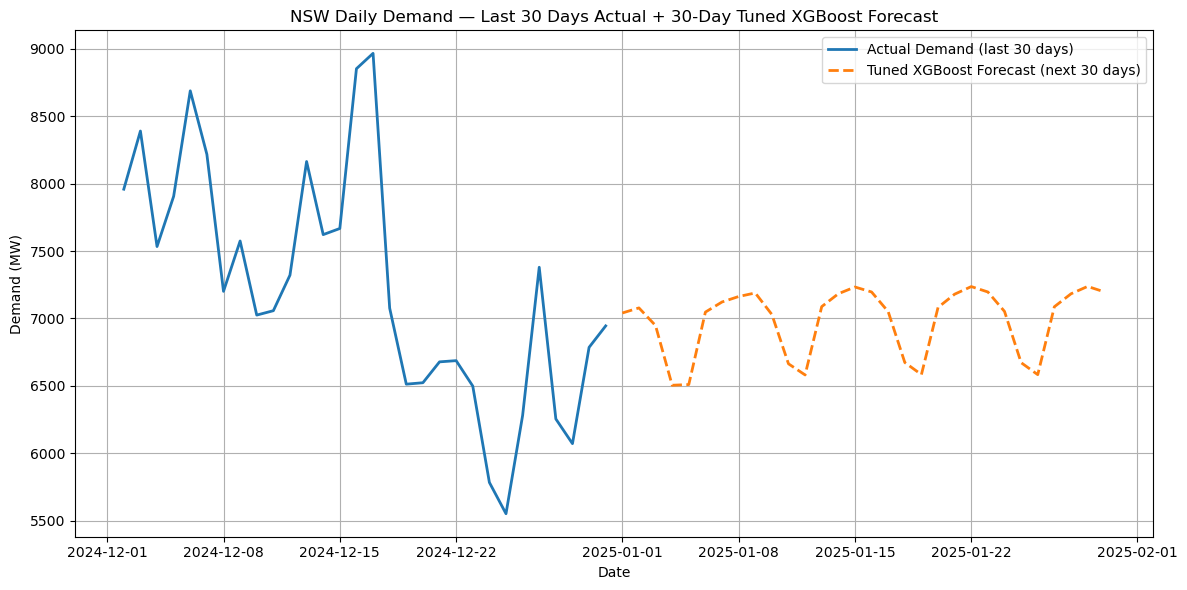

In [29]:
# -------------------------------
# Plot: last 30 days of history + next 30 days forecast
# -------------------------------

# Take last 30 days of actual history
hist_last_30 = daily_fe['demand_MW'].iloc[-30:]

plt.figure(figsize=(12,6))
plt.plot(hist_last_30.index, hist_last_30.values,
         label="Actual Demand (last 30 days)", linewidth=2)
plt.plot(future_df.index, future_df['forecast_demand_MW'].values,
         label="Tuned XGBoost Forecast (next 30 days)", linestyle="--", linewidth=2)

plt.title("NSW Daily Demand — Last 30 Days Actual + 30-Day Tuned XGBoost Forecast")
plt.xlabel("Date")
plt.ylabel("Demand (MW)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## 📈 Step 12 — 30-Day Ahead Forecast (Jan 2025)

Using the **tuned XGBoost model**, we generated a **30-day ahead forecast** of NSW daily operational demand from **1 Jan 2025 to 30 Jan 2025**.  
The chart above shows:

- **Blue line:** Last 30 days of actual demand in Dec 2024  
- **Orange dashed line:** Model forecast for Jan 2025  

---

### 🔧 How the Forecast Was Built

- We started from the **last historical date: 2024-12-31**.
- For each future day (2025-01-01 → 2025-01-30), we:
  - Computed lag features from the updated series:  
    - `lag_1` (yesterday’s demand)  
    - `lag_7` (demand 7 days ago)  
    - 7-day and 30-day rolling averages  
  - Recalculated calendar features:  
    - `day_of_week`, `day_of_year`, `month`, `is_weekend`, and `season`
  - Fed these into the **tuned XGBoost model** to predict that day’s demand.
  - Appended the prediction back into the series so the next day could use it as a lag.

This is a realistic **operational-style recursive forecast**, similar to how system operators roll their forecasts forward each day.

---

### 📊 Behaviour of the Jan 2025 Forecast

From the forecast dataframe:

- First 5 forecasted days:

  - **2025-01-01:** ~7,040 MW  
  - **2025-01-02:** ~7,078 MW  
  - **2025-01-03:** ~6,947 MW  
  - **2025-01-04:** ~6,504 MW  
  - **2025-01-05:** ~6,510 MW  

- Last 5 forecasted days:

  - **2025-01-26:** ~6,583 MW  
  - **2025-01-27:** ~7,087 MW  
  - **2025-01-28:** ~7,183 MW  
  - **2025-01-29:** ~7,238 MW  
  - **2025-01-30:** ~7,198 MW  

### 🔍 Key Patterns

- Forecast demand mostly ranges between **~6,500 MW and ~7,250 MW**.
- A clear **weekly “wave” pattern** appears:
  - Higher values on typical **weekday periods**,
  - Slight dips around **weekends**, driven by `day_of_week` and lag features.
- The model **smooths out extreme spikes** seen in late Dec 2024 but keeps the overall level and seasonally consistent shape for early summer in NSW.

---

### 🧠 Interpretation for Stakeholders

- The forecast provides a **stable, data-driven expectation** of NSW demand for Jan 2025.
- It can be used as:
  - A baseline for **generation scheduling, hedging, and network planning**.
  - An input to **“what-if” scenarios** (e.g. changing temperature, demand response, rooftop PV impact).
- From a portfolio/skills perspective, this demonstrates that you can:
  1. Ingest and preprocess **AEMO operational data**  
  2. Engineer **time-series features** (lags, rolling means, calendar variables)  
  3. Train and tune **advanced ML models (XGBoost)**  
  4. Produce **operational 30-day forecasts** with clear visualisations and interpretation.

---

### ✅ Summary

With this step, the project now covers the **full forecasting pipeline**:

1. **EDA & pattern discovery** (intraday, weekly, seasonal).
2. **Baseline models** (Naive, SARIMA).
3. **Machine learning models** (XGBoost + hyperparameter tuning).
4. **Forward 30-day forecast for Jan 2025** using the best model.

This gives you a strong, end-to-end **energy demand forecasting case study** to showcase on GitHub and LinkedIn.
